# Energy Deposition Histograms

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times New Roman"] + mpl.rcParams["font.serif"]

In [ ]:
# Set up functions necessary for further processing

def prep_output(file_name):
  """
  Takes in the name of the txt file (without .txt) and returns the list of rows.
  """
  output=[]
  with open(file_name + ".txt","r") as file:
    for line in file:
      output.append(line.rstrip('\n'))
  return output


def process_part_data(data_set):
  """
  Takes in the data set for ONE particle type and returns lists with DATA and
  ERROR as predicted by FLUKA in [data, error] format.
  """
  cut = data_set.index("      Percentage errors follow in a matrix A(ir,iz), format (1(5x,1p,10(1x,e11.4)))")
  data_raw = data_set[7:(cut-1)]
  error_raw = data_set[(cut+2):]
  data = []
  error = []
  for line in data_raw:
    for datpoint in line.split():
      data.append(float(datpoint)*1.6e-10*1e13) # note the conversion from GeV/cm^3/primary into J/cm^3
  for line in error_raw:
    for datpoint in line.split():
      error.append(float(datpoint))
  return data, error


def make_array(data, bins_z, bins_r):
  """
  Takes the list of processed data values as well as the number of bins in Z and
  in R, and returs the array of shape (bins_r, bins_z) with respective data values.
  """
  n = 0
  array = []
  for i_z in range(0, bins_z):
    row = []
    for i_r in range(0, bins_r):
      row.append(data[n])
      n += 1
    array.append(row)
  return np.array(array).T


def process_output(raw_output, bins_z, bins_r):
  """
  Cuts the input data by particle types, splits that into data and error, formats
  lists into arrays with respect to bin numbers, and returns a dictionary with particle
  types (detector names from FLUKA) as keywords for each set of data. Specifically
  <detector_nama>_data is the array of data and <detector_name>_error is the respective
  array of errors on the given data values.
  """
  indices = [i for i, val in enumerate(raw_output) if val == '1']
  sorted_data = {}
  sorted_error = {}
  for i in indices:
    line = raw_output[i+1].split()
    particle_name = line[6].strip('"')
    if i == indices[-1]:
      particle_all_data = raw_output[i:]
    else:
      next = indices[indices.index(i)+1]
      particle_all_data = raw_output[i:next]
    particle_data, particle_error = process_part_data(particle_all_data)
    # We now have lists of all data values. Let's turn them into arrays.
    part_data_array = make_array(particle_data, bins_z, bins_r)
    part_error_array = make_array(particle_error, bins_z, bins_r)
    sorted_data[particle_name + '_data'] = part_data_array
    sorted_error[particle_name + '_error'] = part_error_array
  return sorted_data, sorted_error


def quick_plot(dataset):
  """
  Produces a minimalistic plot of the provided data for a quick sanity check
  """
  fig, ax = plt.subplots(figsize=(16, 2))
  im = ax.imshow(dataset, extent=[0, 16, 0, 0.314], origin='lower', aspect='auto', cmap='jet', norm=colors.LogNorm())
  cbar = fig.colorbar(im, ax=ax)
  plt.show()
  return None

def extract_data(file_name):
  """
  Given the file name (without .txt). returns the dictionary with extracted data.
  """
  output = prep_output(file_name)
  r_bin=int(output[2].split()[7])
  z_bin=int(output[3].split()[7])
  processed_data, processed_error = process_output(output, z_bin, r_bin)
  print(f'Detectors registered in {file_name}:')
  for key in processed_data:
    print(key)
  print('\n')
  return processed_data


def name_update(mat_dic):
  """
  Reset the names of the dictionary keys to more user-friendly versions.
  """
  new_mat_dic = {}
  new_mat_dic['Total Energy'] = mat_dic['EnergyDep_data']
  new_mat_dic['Heavy Ions'] = mat_dic['EnHEAVY_data']
  new_mat_dic['Helium-3'] = mat_dic['EnHELIUM-3_data']
  new_mat_dic['Helium-4'] = mat_dic['EnHELIUM-4_data']
  new_mat_dic['Deuteron'] = mat_dic['EnDEUTERON_data']
  new_mat_dic['Triton'] = mat_dic['EnTRITON_data']
  new_mat_dic['Light Ions'] = mat_dic['EnHELIUM-3_data'] + mat_dic['EnHELIUM-4_data'] + \
                              mat_dic['EnDEUTERON_data'] + mat_dic['EnTRITON_data']
  new_mat_dic['All Ions'] = mat_dic['EnHEAVY_data'] + new_mat_dic['Light Ions']
  new_mat_dic['Secondary'] = mat_dic['EnergyProt_data'] - mat_dic['EnergyBP_data']
  new_mat_dic['All Protons'] = mat_dic['EnergyProt_data']
  new_mat_dic['Beam'] = mat_dic['EnergyBP_data']
  new_mat_dic['Neutrons'] = mat_dic['EnergyNeut_data']
  new_mat_dic['Electrons'] = mat_dic['EnergyElec_data']
  new_mat_dic['Photons'] = mat_dic['EnergyPhot_data']
  return new_mat_dic

## Separate Materials

In [ ]:
# Import the file with Ion data (Deuteron, Triton, Helium-3, Helium-4, and Heavy Ions)

file_name = "Graphite_Ion"

with open(file_name + ".txt","r") as file:
    count = 0
    for line in file:
      if count < 10:
        print(line.strip()) # strip() removes extra newline characters
        count += 1
      else:
        break

output = prep_output(file_name)

# get binning parameters from the file
r_min=float(output[2].split()[3])
r_max=float(output[2].split()[5])
r_bin=int(output[2].split()[7])
r_del=float(output[2].split()[10])

z_min=float(output[3].split()[3])
z_max=float(output[3].split()[5])
z_bin=int(output[3].split()[7])
z_del=float(output[3].split()[10])

x_cent=float(output[4].split()[4].rstrip(','))
y_cent=float(output[4].split()[7])

1
R - Z     binning n.   1  "EnDEUTERON" , generalized particle n.  208
R coordinate: from  0.0000E+00 to  3.1400E-01 cm,    32 bins ( 9.8125E-03 cm wide)
Z coordinate: from  0.0000E+00 to  1.6000E+01 cm,   320 bins ( 5.0000E-02 cm wide)
axis coordinates: X = 0.0000E+00, Y =  0.0000E+00 cm
Data follow in a matrix A(ir,iz), format (1(5x,1p,10(1x,e11.4)))

2.8989E-04  6.7107E-04  3.8780E-04  7.3547E-04  8.3723E-04  6.4702E-04  7.4643E-04  4.2941E-04  3.7299E-04  4.6463E-04
3.3453E-04  3.8967E-04  4.1791E-04  3.3082E-04  2.3037E-04  3.0006E-04  2.2076E-04  1.7760E-04  1.2537E-04  1.6617E-04
1.5202E-04  1.5522E-04  9.3142E-05  1.1286E-04  8.9143E-05  4.7645E-05  5.6066E-05  6.6568E-05  4.1754E-05  5.9502E-05


In [ ]:
# Process the output data with the help of the above functions
processed_data, processed_error = process_output(output, z_bin, r_bin)

# Pring the list of keywords to know what to plot
for key in processed_data:
  print(key)

for key in processed_error:
  print(key)

EnDEUTERON_data
EnTRITON_data
EnHELIUM-4_data
EnHELIUM-3_data
EnHEAVY_data
EnDEUTERON_error
EnTRITON_error
EnHELIUM-4_error
EnHELIUM-3_error
EnHEAVY_error


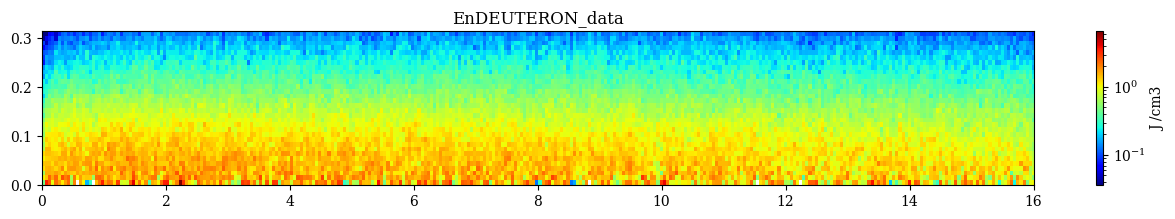

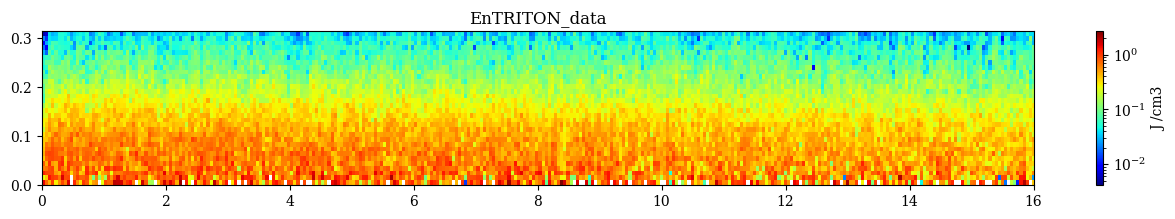

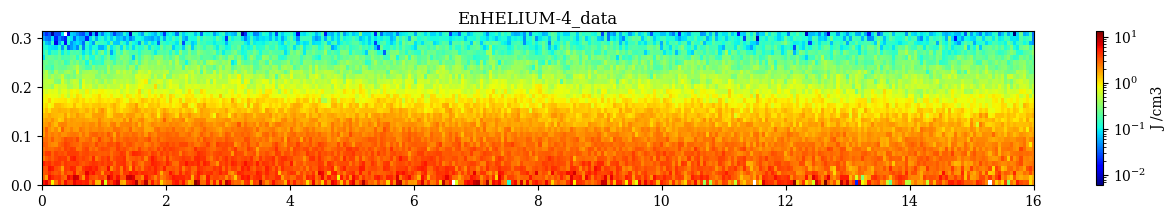

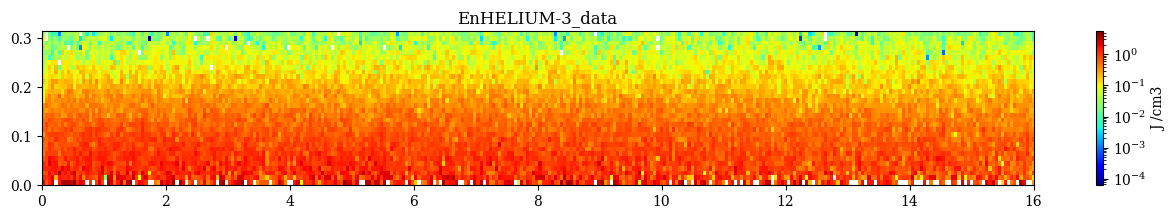

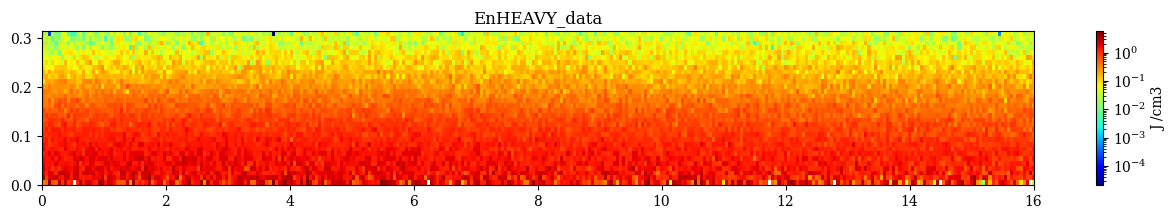

In [ ]:
# Time to plot the results of your effort!!! First, lets plot all the particles

for key in processed_data:
  data = processed_data[key]
  fig, ax = plt.subplots(figsize=(16, 2))
  im = ax.imshow(data, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', cmap='jet', norm=colors.LogNorm())
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('J /cm3')
  ax.set_title(key)
  plt.show()

In [ ]:
# Let's make a combined category for light ions and all ions.

processed_data['LightIons'] = processed_data['EnDEUTERON_data'] + processed_data['EnHELIUM-3_data'] + \
                              processed_data['EnHELIUM-4_data'] + processed_data['EnTRITON_data']
processed_data['AllIons'] = processed_data['EnHEAVY_data'] + processed_data['LightIons']

# Separate data into Light, Heavy, and All Ions
data_light = processed_data['LightIons']
data_heavy = processed_data['EnHEAVY_data']
data_allion = processed_data['AllIons']

# Print out max and min values for all data sets
print(f'Max in LIGHT ions: {data_light.max():.4g} while min is {data_light.min():.4g}')
print(f'Max in HEAVY ions: {data_heavy.max():.4g} while min is {data_heavy.min():.4g}')
print(f'Max in ALL ions: {data_allion.max():.4g} while min is {data_allion.min():.4g}')

Max in LIGHT ions: 18.33 while min is 0.06517
Max in HEAVY ions: 5.652 while min is 0
Max in ALL ions: 20.7 while min is 0.09905


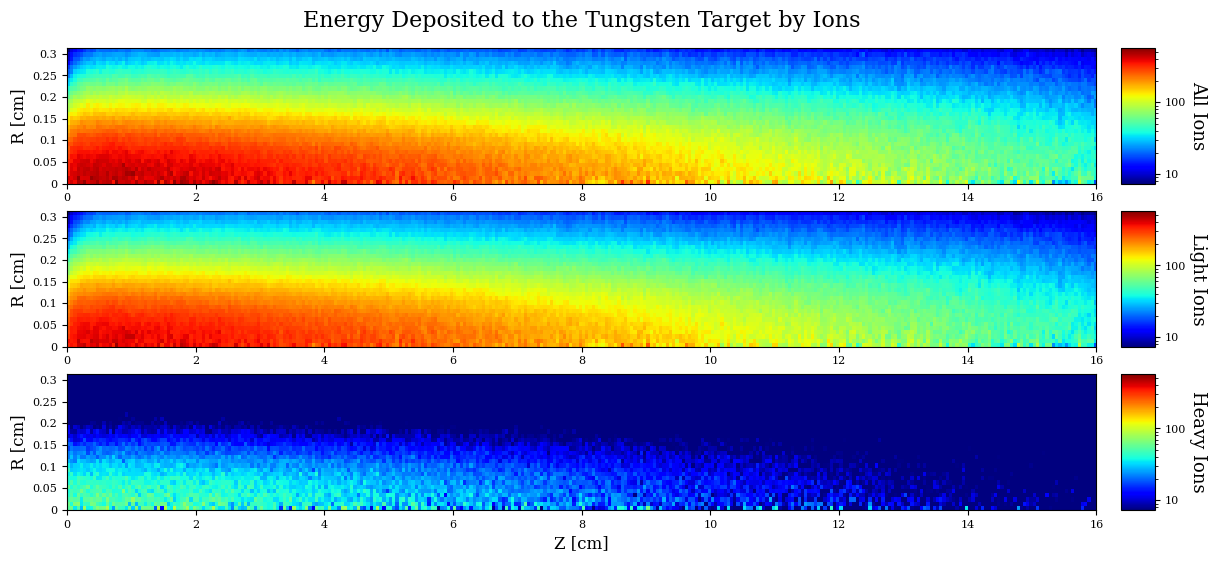

In [ ]:
# Set the max and min value for color bars
pmax = data_allion.max()
pmin = data_allion.min()

tick_values = [10, 100]
tick_labels = ['10', '100']

# ALL IONS
fig, ax = plt.subplots(3, 1, figsize=(16, 6))
im0 = ax[0].imshow(data_allion, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im0, ax=ax[0], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('All Ions', rotation=-90, labelpad=15, fontsize=13)
ax[0].set_title('Energy Deposited to the Tungsten Target by Ions', fontsize=16, pad=15)
ax[0].set_xticks(range(0,18,2))
ax[0].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[0].set_yticks(np.arange(0, 0.35, 0.05))
ax[0].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[0].set_ylabel('R [cm]', fontsize='12')

# LIGHT IONS
im1 = ax[1].imshow(data_light, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im1, ax=ax[1], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('Light Ions', rotation=-90, labelpad=15, fontsize=13)
ax[1].set_xticks(range(0,18,2))
ax[1].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[1].set_yticks(np.arange(0, 0.35, 0.05))
ax[1].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[1].set_ylabel('R [cm]', fontsize='12')

# HEAVY IONS
im2 = ax[2].imshow(data_heavy, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im2, ax=ax[2], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('Heavy Ions', rotation=-90, labelpad=15, fontsize=13)
ax[2].set_xticks(range(0,18,2))
ax[2].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[2].set_yticks(np.arange(0, 0.35, 0.05))
ax[2].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[2].set_xlabel('Z [cm]', fontsize='12')
ax[2].set_ylabel('R [cm]', fontsize='12')



# Save the plot if desired
# plt.savefig('Tungsten_AllIons.png', dpi=300, bbox_inches='tight')

plt.show()

I'm adding extra code to deal with all other particle data.

In [ ]:
# Insert a file with protons, electrons, and stuff

file_name = "Graphite_Particles"

with open(file_name + ".txt","r") as file:
    count = 0
    for line in file:
      if count < 10:
        print(line.strip()) # strip() removes extra newline characters
        count += 1
      else:
        break

output = prep_output(file_name)

1
R - Z     binning n.   1  "EnergyProt" , generalized particle n.  208
R coordinate: from  0.0000E+00 to  3.1400E-01 cm,    32 bins ( 9.8125E-03 cm wide)
Z coordinate: from  0.0000E+00 to  1.6000E+01 cm,   320 bins ( 5.0000E-02 cm wide)
axis coordinates: X = 0.0000E+00, Y =  0.0000E+00 cm
Data follow in a matrix A(ir,iz), format (1(5x,1p,10(1x,e11.4)))

7.6116E-03  7.3616E-03  7.2651E-03  6.9713E-03  6.7056E-03  6.3919E-03  6.3577E-03  5.7442E-03  5.4406E-03  4.9344E-03
4.5611E-03  4.0979E-03  3.7299E-03  3.2069E-03  2.8999E-03  2.6124E-03  2.2282E-03  1.8716E-03  1.5628E-03  1.3044E-03
1.0777E-03  9.1030E-04  7.4206E-04  6.4236E-04  4.9642E-04  3.6546E-04  3.3498E-04  3.0442E-04  2.1724E-04  1.8748E-04


In [ ]:
# Process the output data with the help of the above functions
processed_data, processed_error = process_output(output, z_bin, r_bin)

# Pring the list of keywords to know what to plot
for key in processed_data:
  print(key)

for key in processed_error:
  print(key)

EnergyProt_data
EnergyNeut_data
EnergyElec_data
EnergyPhot_data
EnergyIon_data
EnergyBP_data
EnergyProt_error
EnergyNeut_error
EnergyElec_error
EnergyPhot_error
EnergyIon_error
EnergyBP_error


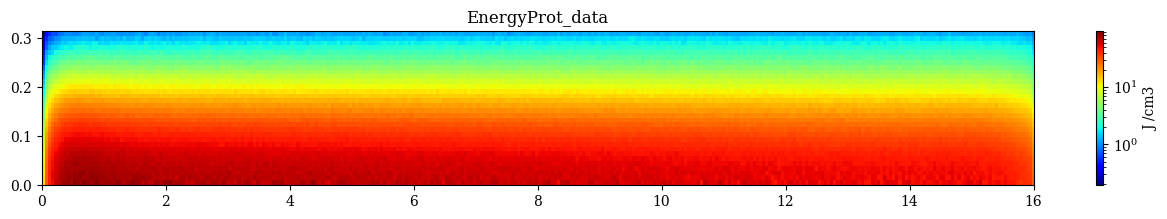

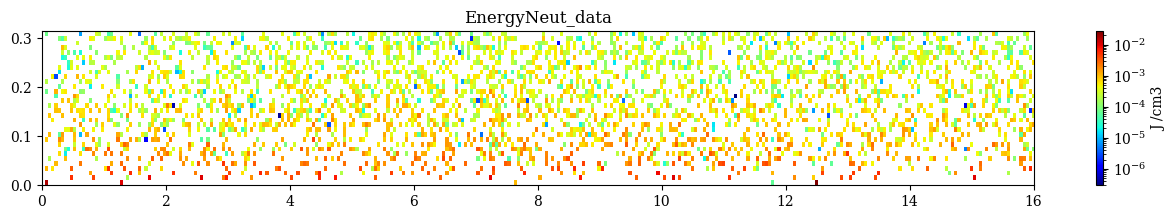

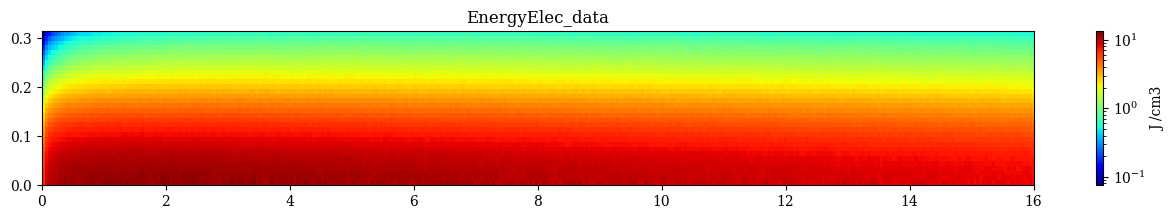

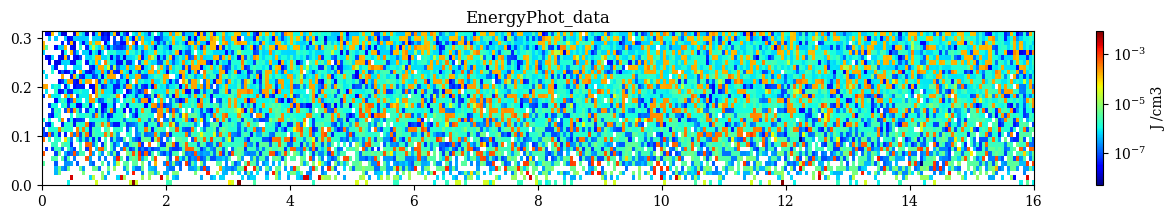

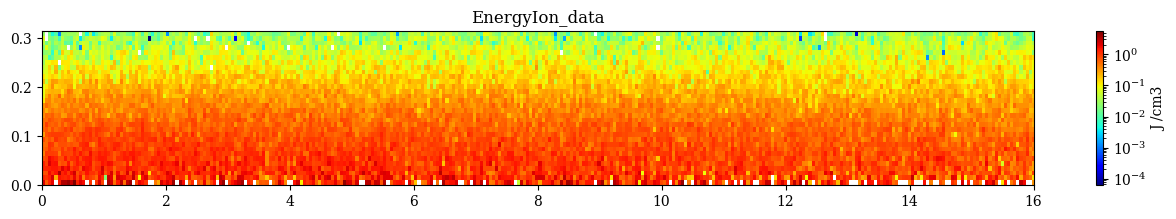

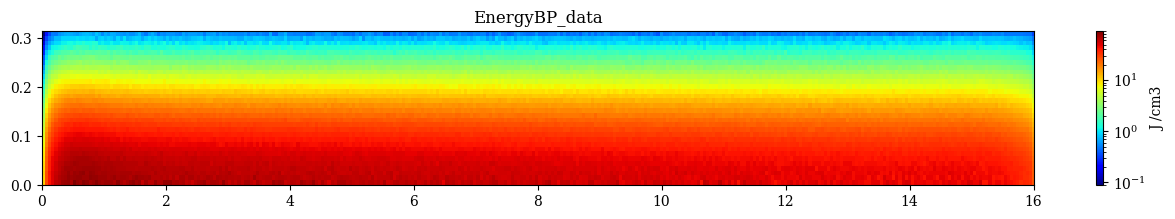

In [ ]:
for key in processed_data:
  data = processed_data[key]
  fig, ax = plt.subplots(figsize=(16, 2))
  im = ax.imshow(data, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', cmap='jet', norm=colors.LogNorm())
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('J /cm3')
  ax.set_title(key)
  plt.show()

In [ ]:
# Collect info about other particles in respective variable
data_prots = processed_data['EnergyProt_data']
data_elecs = processed_data['EnergyElec_data']
data_phots = processed_data['EnergyPhot_data']
data_bprots = processed_data['EnergyBP_data']
data_sprots = data_prots-data_bprots

In [ ]:
# Add total energy deposited from the different file
file_name = 'hfatigue_Graphite_polar'
output = prep_output(file_name)
processed_data, processed_error = process_output(output, z_bin, r_bin)

for key in processed_data:
  print(key)

EnergyDep_data


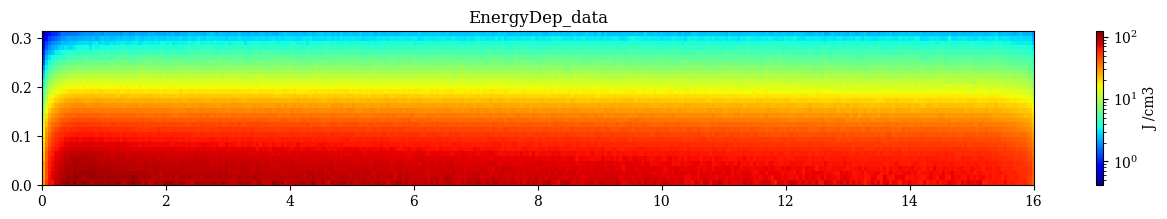

In [ ]:
data_all = processed_data['EnergyDep_data']

fig, ax = plt.subplots(figsize=(16, 2))
im = ax.imshow(data_all, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', cmap='jet', norm=colors.LogNorm())
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('J /cm3')
ax.set_title(key)
plt.show()

In [ ]:
# Let's now print all max and min values to know which scale to chose
print(f'Max in ALL particles: {data_all.max():.4g} while min is {data_all.min():.4g}')
print(f'Max in PROTONS: {data_prots.max():.4g} while min is {data_prots.min():.4g}')
print(f'Max in BEAM PROTONS: {data_bprots.max():.4g} while min is {data_bprots.min():.4g}')
print(f'Max in SEC PROTONS: {data_sprots.max():.4g} while min is {data_sprots.min():.4g}')
print(f'Max in ELECTRONS: {data_elecs.max():.4g} while min is {data_elecs.min():.4g}')
print(f'Max in PHOTONS: {data_phots.max():.4g} while min is {data_phots.min():.4g}')
print(f'Max in LIGHT ions: {data_light.max():.4g} while min is {data_light.min():.4g}')
print(f'Max in HEAVY ions: {data_heavy.max():.4g} while min is {data_heavy.min():.4g}')
print(f'Max in ALL ions: {data_allion.max():.4g} while min is {data_allion.min():.4g}')

Max in ALL particles: 122.7 while min is 0.414
Max in PROTONS: 94.36 while min is 0.1923
Max in BEAM PROTONS: 90.89 while min is 0.08784
Max in SEC PROTONS: 9.69 while min is 0.1045
Max in ELECTRONS: 13.26 while min is 0.07528
Max in PHOTONS: 0.008421 while min is 0
Max in LIGHT ions: 18.33 while min is 0.06517
Max in HEAVY ions: 5.652 while min is 0
Max in ALL ions: 20.7 while min is 0.09905


General plot with all particles of interest on the same scale:

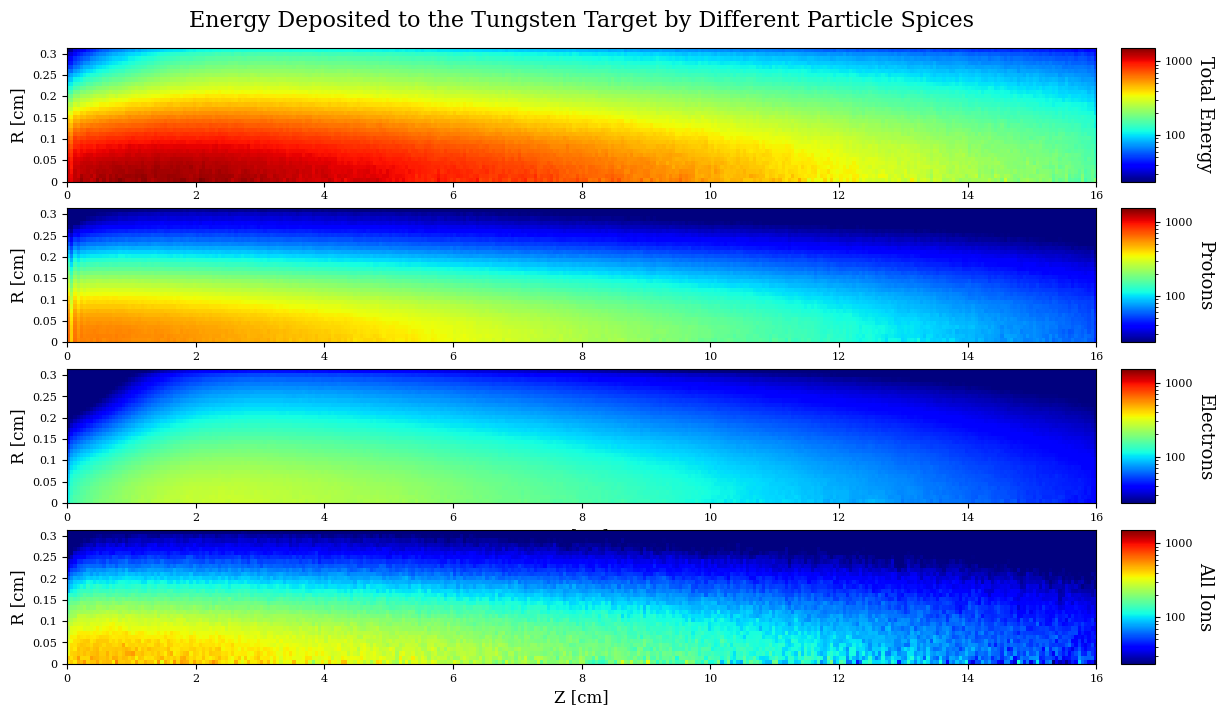

In [ ]:
# Set the max and min value for color bars
pmax = data_all.max()
pmin = data_all.min()

tick_values = [100, 1000]
tick_labels = ['100', '1000']

# ALL PARTICLES
fig, ax = plt.subplots(4, 1, figsize=(16, 8))
im0 = ax[0].imshow(data_all, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im0, ax=ax[0], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('Total Energy', rotation=-90, labelpad=15, fontsize=13)
ax[0].set_title('Energy Deposited to the Tungsten Target by Different Particle Spices', fontsize=16, pad=15)
ax[0].set_xticks(range(0,18,2))
ax[0].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[0].set_yticks(np.arange(0, 0.35, 0.05))
ax[0].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[0].set_ylabel('R [cm]', fontsize='12')

# PROTONS
im1 = ax[1].imshow(data_prots, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im1, ax=ax[1], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('Protons', rotation=-90, labelpad=15, fontsize=13)
ax[1].set_xticks(range(0,18,2))
ax[1].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[1].set_yticks(np.arange(0, 0.35, 0.05))
ax[1].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[1].set_ylabel('R [cm]', fontsize='12')

# ELECTRONS
im2 = ax[2].imshow(data_elecs, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im2, ax=ax[2], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('Electrons', rotation=-90, labelpad=15, fontsize=13)
ax[2].set_xticks(range(0,18,2))
ax[2].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[2].set_yticks(np.arange(0, 0.35, 0.05))
ax[2].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[2].set_xlabel('Z [cm]', fontsize='12')
ax[2].set_ylabel('R [cm]', fontsize='12')

# ALL IONS
im3 = ax[3].imshow(data_allion, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im3, ax=ax[3], aspect=4, pad=0.02)
cbar.set_ticks(tick_values)
cbar.set_ticklabels(tick_labels, fontsize=8)
cbar.set_label('All Ions', rotation=-90, labelpad=15, fontsize=13)
ax[3].set_xticks(range(0,18,2))
ax[3].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[3].set_yticks(np.arange(0, 0.35, 0.05))
ax[3].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[3].set_xlabel('Z [cm]', fontsize='12')
ax[3].set_ylabel('R [cm]', fontsize='12')



# Save the plot if desired
# plt.savefig('Tungsten_TotalEn.png', dpi=300, bbox_inches='tight')

plt.show()

Now let the scale be different for each partile type

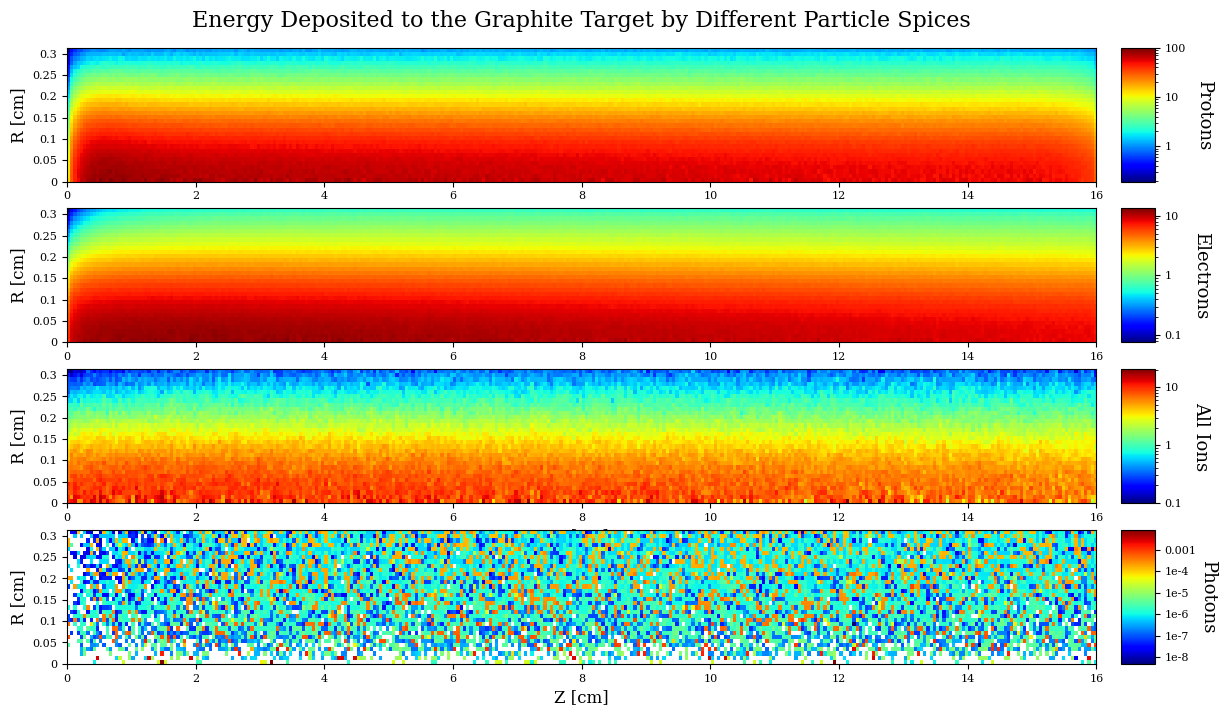

In [ ]:
# PROTONS
fig, ax = plt.subplots(4, 1, figsize=(16, 8))
im0 = ax[0].imshow(data_prots, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm())
cbar = fig.colorbar(im0, ax=ax[0], aspect=4, pad=0.02)
cbar.set_ticks([1, 10, 100])
cbar.set_ticklabels(['1','10', '100'], fontsize=8)
cbar.set_label('Protons', rotation=-90, labelpad=20, fontsize=13)
ax[0].set_title('Energy Deposited to the Graphite Target by Different Particle Spices', fontsize=16, pad=15)
ax[0].set_xticks(range(0,18,2))
ax[0].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[0].set_yticks(np.arange(0, 0.35, 0.05))
ax[0].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[0].set_ylabel('R [cm]', fontsize='12')

# ELECTRONS
im1 = ax[1].imshow(data_elecs, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm())
cbar = fig.colorbar(im1, ax=ax[1], aspect=4, pad=0.02)
cbar.set_ticks([0.1, 1, 10])
cbar.set_ticklabels(['0.1', '1', '10'], fontsize=8)
cbar.set_label('Electrons', rotation=-90, labelpad=20, fontsize=13)
ax[1].set_xticks(range(0,18,2))
ax[1].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[1].set_yticks(np.arange(0, 0.35, 0.05))
ax[1].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[1].set_ylabel('R [cm]', fontsize='12')

# ALL IONS
im2 = ax[2].imshow(data_allion, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm())
cbar = fig.colorbar(im2, ax=ax[2], aspect=4, pad=0.02)
cbar.set_ticks([0.1, 1, 10])
cbar.set_ticklabels(['0.1', '1', '10'], fontsize=8)
cbar.set_label('All Ions', rotation=-90, labelpad=20, fontsize=13)
ax[2].set_xticks(range(0,18,2))
ax[2].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[2].set_yticks(np.arange(0, 0.35, 0.05))
ax[2].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[2].set_xlabel('Z [cm]', fontsize='12')
ax[2].set_ylabel('R [cm]', fontsize='12')

# PHOTONS
im3 = ax[3].imshow(data_phots, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm())
cbar = fig.colorbar(im3, ax=ax[3], aspect=4, pad=0.02)
cbar.set_ticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 0.001])
cbar.set_ticklabels(['1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '0.001'], fontsize=8)
cbar.set_label('Photons', rotation=-90, labelpad=15, fontsize=13)
ax[3].set_xticks(range(0,18,2))
ax[3].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[3].set_yticks(np.arange(0, 0.35, 0.05))
ax[3].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[3].set_xlabel('Z [cm]', fontsize='12')
ax[3].set_ylabel('R [cm]', fontsize='12')



# Save the plot if desired
plt.savefig('Graphite_TotalEnAbs.png', dpi=300, bbox_inches='tight')

plt.show()

Lastly, let's do energy deposited by protons

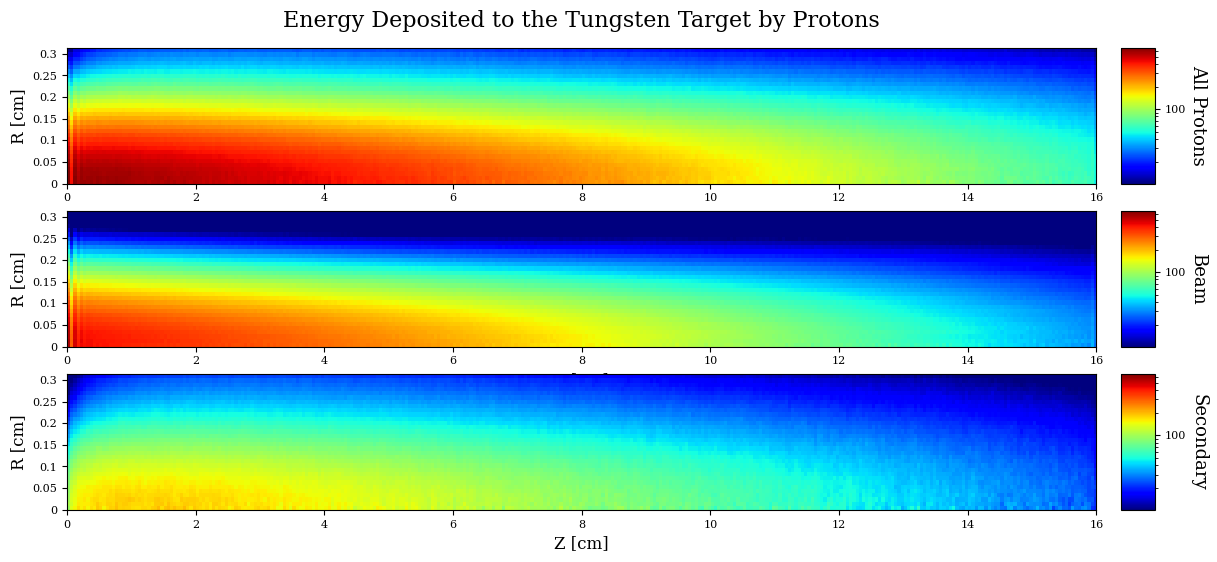

In [ ]:
# Set the max and min value for color bars
pmax = data_prots.max()
pmin = data_prots.min()

# TOTAL ENERGY
fig, ax = plt.subplots(3, 1, figsize=(16, 6))
im0 = ax[0].imshow(data_prots, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im0, ax=ax[0], aspect=4, pad=0.02)
cbar.set_ticks([100])
cbar.set_ticklabels(['100'], fontsize=8)
cbar.set_label('All Protons', rotation=-90, labelpad=15, fontsize=13)
ax[0].set_title('Energy Deposited to the Tungsten Target by Protons', fontsize=16, pad=15)
ax[0].set_xticks(range(0,18,2))
ax[0].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[0].set_yticks(np.arange(0, 0.35, 0.05))
ax[0].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[0].set_ylabel('R [cm]', fontsize='12')

# BEAM PROTONS
im1 = ax[1].imshow(data_bprots, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im1, ax=ax[1], aspect=4, pad=0.02)
cbar.set_ticks([100])
cbar.set_ticklabels(['100'], fontsize=8)
cbar.set_label('Beam', rotation=-90, labelpad=15, fontsize=13)
ax[1].set_xticks(range(0,18,2))
ax[1].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[1].set_yticks(np.arange(0, 0.35, 0.05))
ax[1].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[1].set_xlabel('Z [cm]', fontsize='12')
ax[1].set_ylabel('R [cm]', fontsize='12')

# SECONDARY PROTONS
im2 = ax[2].imshow(data_sprots, extent=[z_min, z_max, r_min, r_max], origin='lower', aspect='auto', \
               cmap='jet', norm=colors.LogNorm(vmin=pmin, vmax=pmax))
cbar = fig.colorbar(im2, ax=ax[2], aspect=4, pad=0.02)
cbar.set_ticks([100])
cbar.set_ticklabels(['100'], fontsize=8)
cbar.set_label('Secondary', rotation=-90, labelpad=15, fontsize=13)
ax[2].set_xticks(range(0,18,2))
ax[2].set_xticklabels(['0', '2', '4', '6', '8', '10', '12', '14', '16'], fontsize='8')
ax[2].set_yticks(np.arange(0, 0.35, 0.05))
ax[2].set_yticklabels(['0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3'], fontsize='8')
ax[2].set_xlabel('Z [cm]', fontsize='12')
ax[2].set_ylabel('R [cm]', fontsize='12')


# Save the plot if desired
plt.savefig('Tungsten_Protons.png', dpi=300, bbox_inches='tight')

plt.show()

## Comparison Accross Materials

In [ ]:
tung_dic = {}
inc_dic = {}
graph_dic = {}

for datatype in ['_Ion', '_Particles', '_total']:
  tung_dic.update(extract_data('Tungsten'+datatype))
  inc_dic.update(extract_data('Inconel'+datatype))
  graph_dic.update(extract_data('Graphite'+datatype))

Detectors registered in Tungsten_Ion:
EnDEUTERON_data
EnTRITON_data
EnHELIUM-4_data
EnHELIUM-3_data
EnHEAVY_data


Detectors registered in Inconel_Ion:
EnDEUTERON_data
EnTRITON_data
EnHELIUM-4_data
EnHELIUM-3_data
EnHEAVY_data


Detectors registered in Graphite_Ion:
EnDEUTERON_data
EnTRITON_data
EnHELIUM-4_data
EnHELIUM-3_data
EnHEAVY_data


Detectors registered in Tungsten_Particles:
EnergyProt_data
EnergyNeut_data
EnergyElec_data
EnergyPhot_data
EnergyIon_data
EnergyBP_data


Detectors registered in Inconel_Particles:
EnergyProt_data
EnergyNeut_data
EnergyElec_data
EnergyPhot_data
EnergyIon_data
EnergyBP_data


Detectors registered in Graphite_Particles:
EnergyProt_data
EnergyNeut_data
EnergyElec_data
EnergyPhot_data
EnergyIon_data
EnergyBP_data


Detectors registered in Tungsten_total:
EnergyDep_data


Detectors registered in Inconel_total:
EnergyDep_data


Detectors registered in Graphite_total:
EnergyDep_data




In [ ]:
tung = name_update(tung_dic)
inc = name_update(inc_dic)
graph = name_update(graph_dic)

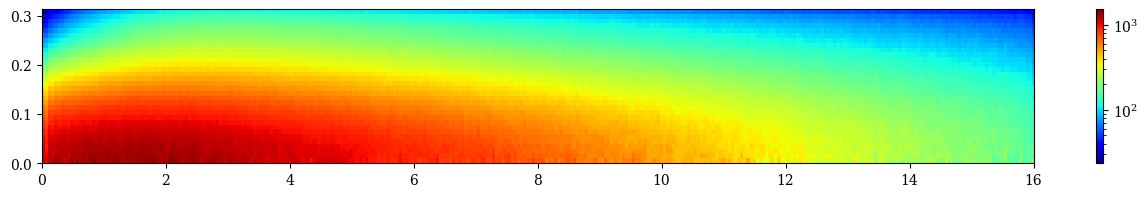

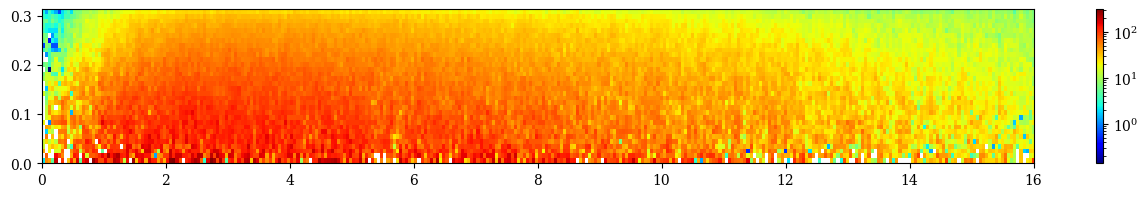

In [ ]:
tung_strip = tung['Total Energy'] - tung['All Protons'] - tung['All Ions'] - tung['Electrons'] - tung['Photons']

quick_plot(tung['Total Energy'])
quick_plot(tung_strip)